In [16]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import napari 
import NRSS
import PyHyperScattering
import sys
sys.path.append(r'C:\Users\Phong\Box\Research\Mixed Conduction Project\RSOXS Projects\Shared RSoXS Folder\DopantModeling/')
from src.Morphology.Fibril.FibrilGenerator import generate_morphology, FibrilGenerator, FibrilSizeParams, FibrilGrowthParams, FibrilOrientationParams, FibrilOrientation, FibrilDistribution
from src.Morphology.Fibril.FibrilPostProcessor import process_morphology, read_crystalline_mol_frac_from_file, DopantOrientation
from tqdm import tqdm
from NRSS.writer import write_materials, write_hdf5, write_config
from NRSS.checkH5 import checkH5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Generating field...


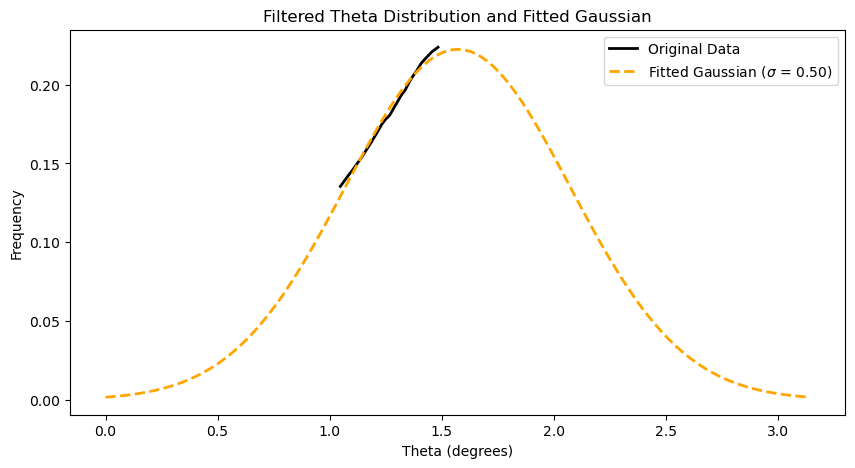

Generating theta field from fit sigma...
Generating field...
Generating fibril centers from Poisson disk sampling...
18 / 55


In [18]:
x_dim_nm = 256
y_dim_nm = x_dim_nm
z_dim_nm = 256
pitch_nm = 2

# Initialize fibril generator
fibgen = FibrilGenerator(x_dim_nm, y_dim_nm, z_dim_nm, pitch_nm)

# Define fibril generator parameters
fibril_size_params = FibrilSizeParams(
    radius_nm_avg=15, 
    radius_nm_std=3,
    min_fibril_length_nm=100, 
    max_fibril_length_nm=400
)

fibril_growth_params = FibrilGrowthParams(
    max_num_fibrils=9999, 
    fibril_distribution=FibrilDistribution.PDS,
    c2c_dist_nm=45, 
    symmetrical_growth=True, 
    periodic_bc=True
)

f=0.05
fibril_orientation_params = FibrilOrientationParams(
    fibril_orientation=FibrilOrientation.GRF_SAMPLE_ALL,
    theta_distribution_csv = r'C:\Users\Phong\Box\Research\Mixed Conduction Project\RSOXS Projects\Shared RSoXS Folder\DopantModeling\data\theta_distributions\avg_0p1_theta_distribution.csv',
    k=1./25,
    std=1./125
)

# Set fibril generator parameters
fibgen.set_model_parameters(
    fibril_size_params=fibril_size_params, 
    fibril_growth_params=fibril_growth_params,
    fibril_orientation_params=fibril_orientation_params
)

# Fill model with fibrils
fibgen.fill_model()

In [19]:
viewer, layer = visualize_morphology(fibgen.box)

NameError: name 'visualize_morphology' is not defined

In [ ]:
from napari_animation import Animation

def add(tuple1, tuple2):
    return tuple(x + y for x, y in zip(tuple1, tuple2))

viewer = napari.Viewer(ndisplay=3)
# viewer.window.resize(1600,1200)
layer = viewer.add_image(fibgen.box)
# layer.blending = 'additive'
layer.blending = 'translucent_no_depth'
layer.interpolation = 'cubic'
layer.colormap = 'twilight_shifted'
# layer.colormap = 'inferno'
layer.rendering = 'attenuated_mip'
layer.attenuation = 0.03

# viewer.camera.angles = (35.264, 45, 0)
# viewer.camera.zoom = 0.9

initial_angle = (90, 35.264, 135)
initial_zoom = 1.5
num_steps = 120

viewer.camera.angles = initial_angle
viewer.camera.zoom = initial_zoom

animation = Animation(viewer)

viewer.camera.angles = initial_angle
animation.capture_keyframe()
# viewer.camera.zoom = 2.4
# animation.capture_keyframe()
current_angle = add(initial_angle, (0, 0, 90))
viewer.camera.angles = current_angle
animation.capture_keyframe(steps=num_steps)

current_angle = add(current_angle, (0, 0, 90))
viewer.camera.angles = current_angle
animation.capture_keyframe(steps=num_steps)

current_angle = add(current_angle, (0, 0, 90))
viewer.camera.angles = current_angle
animation.capture_keyframe(steps=num_steps)

current_angle = add(current_angle, (0, 0, 90))
viewer.camera.angles = current_angle
animation.capture_keyframe(steps=num_steps)

animation.animate('demo.mp4', canvas_only=True, fps=60, quality=9)

napari.run()


In [ ]:
print(viewer.camera.zoom)
print(viewer.camera.angles)
print(layer.attenuation)

In [ ]:
from src.Morphology.FibrilGenerator import FieldType
fibgen.plot_field(field_type=FieldType.PSI)
plt.show()

In [ ]:
from src.Morphology.FibrilGenerator import Materials
from src.Morphology.FibrilPostProcessor import FibrilPostProcessor, MaterialParams, SurfaceRoughnessParams, CoreShellParams, MatrixParams, DopantParams

from src.Morphology.FibrilPostProcessor import DopantOrientation

mw = {
    Materials.CRYSTAL_ID: 166.2842, # Molecular weight of crystalline P3HT repeat
    Materials.AMORPH_ID: 166.2842,  # Molecular weight of amorphous P3HT repeat
    Materials.DOPANT_ID: 276.15     # Molecular weight of TFSI- = 280.14, Molecular weight of F4TCNQ = 276.15
}

density = {
    Materials.CRYSTAL_ID: 1.1, # Density of crystalline P3HT
    Materials.AMORPH_ID: 1.1,  # Density of amorphous P3HT
    Materials.DOPANT_ID: 1.1   # Density of dopant in P3HT
}

material_params = MaterialParams(
    num_materials=4, mw=mw, density=density)

core_shell_params = CoreShellParams(
    gaussian_std=3, fibril_shell_cutoff=0.2)

matrix_params = MatrixParams(
    amorph_matrix_Vfrac=0.9, amorph_orientation=True)

surface_roughness_params = SurfaceRoughnessParams(
    height_feature=3,max_valley_nm=43)
surface_roughness_params = None

dopant_params = DopantParams(
    dopant_vol_frac=0.0, crystal_dopant_frac=1.0,
    dopant_orientation=DopantOrientation.ISOTROPIC)
dopant_params = None

post_processor = FibrilPostProcessor(
    material_params=material_params,
    matrix_params=matrix_params,
    surface_roughness_params=surface_roughness_params,
    core_shell_params=core_shell_params,
    dopant_params=dopant_params)

In [ ]:
data = fibgen.create_morphology_data()
data = post_processor.process(data)
post_processor.save_parameters('Fibril', data, fibgen)

In [ ]:
write_hdf5(data.get_data()[0:3], float(data.pitch_nm), 'Fibril.hdf5')

In [ ]:
# checkH5('1024x1024x512nm_pitch2nm_rad15nm_std3nm_1250fib_100-400nm.hdf5', z_slice=55)

In [ ]:
from NRSS.checkH5 import animateH5

figs = checkH5('Fibril.hdf5', z_slice=128)
# animateH5('Fibril.hdf5')

In [ ]:
# figs[0].savefig('mat0.png')
for i, fig in enumerate(figs):
    fig.savefig(f'mat_{i+1}.png')

In [ ]:
energies1 = np.round(np.arange(280., 286., 0.5),1)
energies2 = np.round(np.arange(286., 288., 0.2),1)
energies3 = np.round(np.arange(288., 291.5, 0.5),1)
energies = np.concatenate([energies1, energies2, energies3])
# energies = np.round(np.arange(280., 295., 1),1)
print(energies)

material_dict = {
    'Material1': 'vacuum', 
    'Material2': 'interp_P3HT_database_kkcalc_merge.txt', 
    'Material3': 'interp_P3HT_database_kkcalc_merge_isotropic.txt',
    'Material4': 'vacuum'
}
energy_dict = {
    'Energy': 6,
    'DeltaPerp': 3,
    'BetaPerp': 1,
    'DeltaPara': 2,
    'BetaPara': 0 
}

write_materials(energies, material_dict, energy_dict, 3)
write_config(list(energies), [0.0, 1.0, 360.0], CaseType=0, MorphologyType=0)

In [ ]:
import subprocess

subprocess.run(['CyRSoXS', 'test/Fibril.hdf5'])

In [ ]:
import pathlib
from PyHyperScattering.load import cyrsoxsLoader
from PyHyperScattering.integrate import WPIntegrator

basePath = pathlib.Path('.').absolute()
h5path = pathlib.Path(basePath,'HDF5')
h5list = list(sorted(h5path.glob('*h5')))
print(h5list)

load = cyrsoxsLoader()
integ = WPIntegrator()
raw = load.loadDirectory(basePath, PhysSize=2)
remeshed = integ.integrateImageStack(raw)


start_q = 0.1
end_q = 0.9

# para = remeshed.rsoxs.slice_chi(90, chi_width = 45).sel(q = slice(start_q, end_q)) + remeshed.rsoxs.slice_chi(-90, chi_width = 45).sel(q = slice(start_q, end_q))
# perp = remeshed.rsoxs.slice_chi(0, chi_width = 45).sel(q = slice(start_q, end_q)) + remeshed.rsoxs.slice_chi(180, chi_width = 45).sel(q = slice(start_q, end_q))
para = remeshed.rsoxs.slice_chi(90, chi_width = 45) + remeshed.rsoxs.slice_chi(-90, chi_width = 45)
perp = remeshed.rsoxs.slice_chi(0, chi_width = 45)  + remeshed.rsoxs.slice_chi(180, chi_width = 45)


AR = (para - perp)/(para + perp)


# 0.01 - 0.09 inverse angstroms

# If in angstroms, 0.01 - 0.09 inverse angstroms

# If in nanometers, 0.1 / (10 * angstroms) - 0.9 inverse nanometers

In [ ]:
from matplotlib import cm
from matplotlib.colors import LogNorm

c = cm.jet(np.linspace(0,1,len(remeshed)))
fig, ax = plt.subplots(1,3,figsize=(10,3),dpi=140,constrained_layout=True)
raw.sel(energy=283).plot(norm=LogNorm(1e-2,1e7),cmap='terrain',ax=ax[0],add_colorbar=False)
raw.sel(energy=285).plot(norm=LogNorm(1e-2,1e7),cmap='terrain',ax=ax[1],add_colorbar=False)
raw.sel(energy=286).plot(norm=LogNorm(1e-2,1e7),cmap='terrain',ax=ax[2])

[{axes.set_xlim(-end_q,end_q),axes.set_ylim(-end_q,end_q)} for axes in ax]
plt.show()

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(10,6),dpi=140,constrained_layout=True)
axs = axs.flatten()
end_q = 0.9

raw.sel(energy=280).plot(x='qx',y='qy',norm=LogNorm(1e-1,1e7),cmap='terrain',ax=axs[0],add_colorbar=False)
raw.sel(energy=282).plot(x='qx',y='qy',norm=LogNorm(1e-1,1e7),cmap='terrain',ax=axs[1],add_colorbar=False)
raw.sel(energy=284).plot(x='qx',y='qy',norm=LogNorm(1e-1,1e7),cmap='terrain',ax=axs[2])
raw.sel(energy=286).plot(x='qx',y='qy',norm=LogNorm(1e-1,1e7),cmap='terrain',ax=axs[3],add_colorbar=False)
raw.sel(energy=288).plot(x='qx',y='qy',norm=LogNorm(1e-1,1e7),cmap='terrain',ax=axs[4],add_colorbar=False)
raw.sel(energy=290).plot(x='qx',y='qy',norm=LogNorm(1e-1,1e7),cmap='terrain',ax=axs[5])

[{ax.set_xlim(-end_q,end_q),
  ax.set_ylim(-end_q,end_q),
  ax.set_xlabel('$q_x$ (nm$^{-1}$)'),
  ax.set_ylabel('$q_y$ (nm$^{-1}$)')} 
  for ax in axs]
plt.show()



In [ ]:
# calculate the anisotropy metric
A = remeshed.rsoxs.AR(chi_width=45)

In [ ]:
axs.flatten()

In [ ]:
A.plot(x='q',cmap='RdBu')
plt.xlim(left=start_q, right=end_q)
plt.ylim(bottom=280, top=290)
plt.xscale('linear')
plt.xlabel('q (nm$^{-1}$)')
plt.ylabel('Energy (eV)')
plt.show()

In [ ]:
AR.plot(x='q',cmap='RdBu_r')
plt.xlim(left=start_q, right=end_q)
plt.ylim(bottom=280, top=290)
plt.xscale('linear')
plt.show()

In [ ]:
from src.Visualization.plot import plot_anisotropy_EvQ

plot_anisotropy_EvQ(AR, (start_q, end_q))

In [ ]:
A.plot(x='q',cmap='bwr_r')
plt.xlim(left=start_q, right=end_q)
plt.ylim(bottom=280, top=290)
plt.xscale('linear')
plt.show()

In [ ]:
d_start = 10 # Angstroms
q_start = 2*np.pi/d_start 

d_end = 100 # Angstroms
q_end = 2*np.pi/d_end

print(q_start, q_end)

In [ ]:
q_start = 0.01 * 10 # nm^-1
d_start = 2*np.pi/q_start # nm

q_end = 0.04 * 10 # nm^-1
d_end = 2*np.pi/q_end # nm


print(d_start, d_end)

In [ ]:


horz = remeshed.rsoxs.slice_chi(0, chi_width=20)
vert = remeshed.rsoxs.slice_chi(90, chi_width=20)



In [ ]:
from src.Visualization.plot import plot_intensity_EvQ, plot_para_perp

plot_intensity_EvQ(horz, (start_q, end_q), label='parallel')
plot_intensity_EvQ(vert, (start_q, end_q), label='perpendicular')
plot_para_perp(horz, vert, I_range=(1e-3, 1e6))

In [ ]:


# vert.plot(x='q',cmap='terrain',norm=LogNorm(1e-1,1e7), xscale='linear')
# plt.xlim(left=0.01, right=1)
# plt.show()



In [ ]:

# energy = 285
# vert.sel(energy=energy).plot(yscale='log',xscale='linear')
# horz.sel(energy=energy).plot(yscale='log',xscale='linear')
# plt.xlim(left=start_q, right=end_q)
# plt.ylim(bottom=1e-5, top=1e6)
# plt.legend(['Para', 'Perp'])
# plt.xlabel('q (nm$^{-1}$)')
# plt.ylabel('Intensity (a.u.)')
# plt.show()



In [ ]:
# horz.sel(energy=slice(280, 300)).energy

In [ ]:
# import pandas as pd
# file_path_p3ht = 'P3HT.txt'
# # Attempting to read the file again with a flexible approach for space or tab delimiters
# try:
#     # Pandas can handle variable whitespace as a separator using regex
#     df_p3ht = pd.read_csv(file_path_p3ht, delim_whitespace=True)
# except Exception as e:
#     error_message = str(e)

# df_p3ht.head() if 'df_p3ht' in locals() else error_message


In [ ]:
# import pandas as pd
# from sklearn.linear_model import LinearRegression

# # Load your data
# df = pd.read_csv('interp_P3HT_database_kkcalc_merge_isotropic.txt', delimiter='\t')
# df = df[(df['energy'] >= 280) & (df['energy'] <= 300)]

# X_beta = df[['beta_para', 'beta_perp']]
# y_beta = df['beta']
# reg_beta = LinearRegression().fit(X_beta, y_beta)
# coefficients_beta = reg_beta.coef_

# X_delta = df[['delta_para', 'delta_perp']]
# y_delta = df['delta']
# reg_delta = LinearRegression().fit(X_delta, y_delta)
# coefficients_delta = reg_delta.coef_

# print("Coefficients for beta:", coefficients_beta)
# print("Coefficients for delta:", coefficients_delta)





In [ ]:
plt.plot(df['energy'], y_beta)
# plt.plot(df['energy'], X_beta * coefficients_delta)
plt.show()

In [ ]:
fit_beta = X_beta['beta_para'] * coefficients_beta[0] + X_beta['beta_perp'] * coefficients_beta[1]
fit_beta = X_beta['beta_para'] * 0.333333333 + X_beta['beta_perp'] * 0.66666666666
plt.plot(df['energy'], fit_beta)
plt.plot(df['energy'], y_beta)
plt.xlim([284, 286])
plt.show()

In [ ]:
from src.Common.files import move

move('HDF5', 'test/')

In [ ]:
move('config.txt', 'test/')